## Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import joblib

## 📥 Chargement des jeux de données
Nous chargeons plusieurs versions du dataset préparé : 
- PCA (95 dimensions)
- Features sélectionnées par Random Forest
- Vecteur latent généré par Autoencoder (5D)
Ces trois représentations seront utilisées pour entraîner et comparer plusieurs modèles.

In [2]:
# Chargement des représentations de X
X_pca = pd.read_csv("../datasets/pca_95.csv")
X_rf = pd.read_csv("../datasets/rf_selected.csv")
X_autoenc = pd.read_csv("../datasets/autoencoded_5D.csv")

# Chargement des étiquettes
y = pd.read_csv("../datasets/labels.csv").squeeze()  # Convert to Series

# Vérification des shapes
print("Shapes des datasets :")
print("PCA     :", X_pca.shape)
print("RF      :", X_rf.shape)
print("AutoEnc :", X_autoenc.shape)
print("Labels  :", y.shape)

Shapes des datasets :
PCA     : (1042, 95)
RF      : (1042, 31)
AutoEnc : (1042, 5)
Labels  : (1042,)


## ✂️ Séparation des données en Train/Test
Nous divisons les jeux de données en ensembles d’entraînement et de test (80/20) avec stratification pour préserver la distribution des classes (Goodware vs Ransomware).

In [3]:
# Split pour PCA
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Split pour RF-selected
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(
    X_rf, y, test_size=0.2, random_state=42, stratify=y)

# Split pour AutoEncoder 5D
X_auto_train, X_auto_test, y_auto_train, y_auto_test = train_test_split(
    X_autoenc, y, test_size=0.2, random_state=42, stratify=y)

# Vérification des shapes
print("✅ Split terminé !")
print("PCA     :", X_pca_train.shape, X_pca_test.shape)
print("RF      :", X_rf_train.shape, X_rf_test.shape)
print("AutoEnc :", X_auto_train.shape, X_auto_test.shape)

✅ Split terminé !
PCA     : (833, 95) (209, 95)
RF      : (833, 31) (209, 31)
AutoEnc : (833, 5) (209, 5)


## 🌲 Random Forest sur données réduites par PCA
Nous entraînons un modèle Random Forest sur les 95 composantes principales extraites via PCA.  
Les performances sont évaluées via Accuracy, Précision, Recall, F1-Score, et matrice de confusion.

📊 Scores - Random Forest (PCA)
Accuracy  : 0.8900
Precision : 0.9355
Recall    : 0.8365
F1-Score  : 0.8832


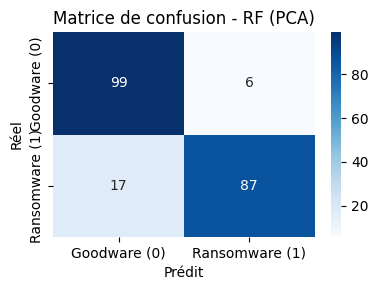

In [4]:
# Entraînement du modèle
rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca.fit(X_pca_train, y_pca_train)

# Prédictions
y_pred_pca = rf_pca.predict(X_pca_test)

# Évaluation
acc = accuracy_score(y_pca_test, y_pred_pca)
prec = precision_score(y_pca_test, y_pred_pca)
rec = recall_score(y_pca_test, y_pred_pca)
f1 = f1_score(y_pca_test, y_pred_pca)

print("📊 Scores - Random Forest (PCA)")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-Score  : {f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_pca_test, y_pred_pca)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Goodware (0)', 'Ransomware (1)'], yticklabels=['Goodware (0)', 'Ransomware (1)'])
plt.title("Matrice de confusion - RF (PCA)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.savefig("../visuals/cm_rf_pca.png", dpi=300)
plt.show()

## 🌲 Random Forest sur données RF-selected
Nous utilisons uniquement les 31 features sélectionnées selon leur importance avec Random Forest.  
L’objectif est d’atteindre des performances élevées tout en réduisant la complexité du modèle.

📊 Scores - Random Forest (RF-selected)
Accuracy  : 0.8947
Precision : 0.9362
Recall    : 0.8462
F1-Score  : 0.8889


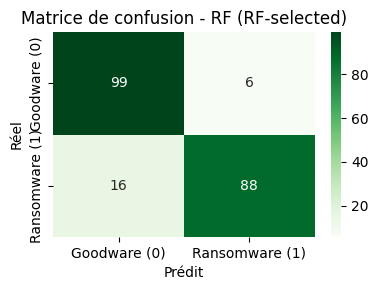

In [5]:
# Entraînement du modèle sur RF-selected
rf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_rf.fit(X_rf_train, y_rf_train)

# Prédictions
y_pred_rf = rf_rf.predict(X_rf_test)

# Évaluation
acc = accuracy_score(y_rf_test, y_pred_rf)
prec = precision_score(y_rf_test, y_pred_rf)
rec = recall_score(y_rf_test, y_pred_rf)
f1 = f1_score(y_rf_test, y_pred_rf)

print("📊 Scores - Random Forest (RF-selected)")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-Score  : {f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_rf_test, y_pred_rf)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=['Goodware (0)', 'Ransomware (1)'], yticklabels=['Goodware (0)', 'Ransomware (1)'])
plt.title("Matrice de confusion - RF (RF-selected)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.savefig("../visuals/cm_rf_rfselected.png", dpi=300)
plt.show()

## 🌲 Random Forest sur représentation compressée (AutoEncoder 5D)
Nous évaluons un Random Forest entraîné sur les 5 dimensions issues du goulot d’étranglement de l’autoencodeur.  
Objectif : mesurer la qualité d’une compression profonde tout en maintenant de bonnes performances.

📊 Scores - Random Forest (AutoEncoder 5D)
Accuracy  : 0.8469
Precision : 0.8673
Recall    : 0.8173
F1-Score  : 0.8416


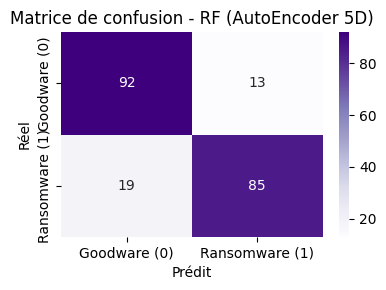

In [6]:
# Entraînement du modèle sur AutoEncoder (5D)
rf_ae = RandomForestClassifier(n_estimators=100, random_state=42)
rf_ae.fit(X_auto_train, y_auto_train)

# Prédictions
y_pred_ae = rf_ae.predict(X_auto_test)

# Évaluation
acc = accuracy_score(y_auto_test, y_pred_ae)
prec = precision_score(y_auto_test, y_pred_ae)
rec = recall_score(y_auto_test, y_pred_ae)
f1 = f1_score(y_auto_test, y_pred_ae)

print("📊 Scores - Random Forest (AutoEncoder 5D)")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-Score  : {f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_auto_test, y_pred_ae)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=['Goodware (0)', 'Ransomware (1)'], yticklabels=['Goodware (0)', 'Ransomware (1)'])
plt.title("Matrice de confusion - RF (AutoEncoder 5D)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.savefig("../visuals/cm_rf_autoencoder.png", dpi=300)
plt.show()

## 🔎 Modélisation SVM - Données PCA (95 dimensions)

📊 Scores - SVM (PCA)
              precision    recall  f1-score   support

           0     1.0000    0.3048    0.4672       105
           1     0.5876    1.0000    0.7402       104

    accuracy                         0.6507       209
   macro avg     0.7938    0.6524    0.6037       209
weighted avg     0.7948    0.6507    0.6030       209



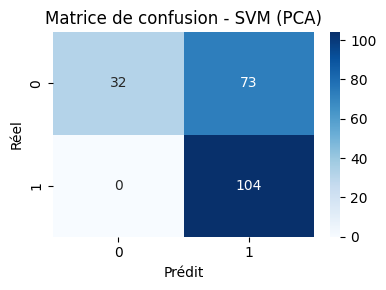

In [7]:
# Modèle SVM
svm_pca = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_pca.fit(X_pca_train, y_pca_train)

# Prédictions
y_pred_svm_pca = svm_pca.predict(X_pca_test)

# Évaluation
print("📊 Scores - SVM (PCA)")
print(classification_report(y_pca_test, y_pred_svm_pca, digits=4))

# Matrice de confusion
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_pca_test, y_pred_svm_pca), annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion - SVM (PCA)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.savefig("../visuals/confusion_svm_pca.png", dpi=300)
plt.show()

## 🔎 Modélisation SVM - Données RF-selected (31 dimensions)

📊 Scores - SVM (RF-selected)
              precision    recall  f1-score   support

           0     0.9487    0.3524    0.5139       105
           1     0.6000    0.9808    0.7445       104

    accuracy                         0.6651       209
   macro avg     0.7744    0.6666    0.6292       209
weighted avg     0.7752    0.6651    0.6287       209



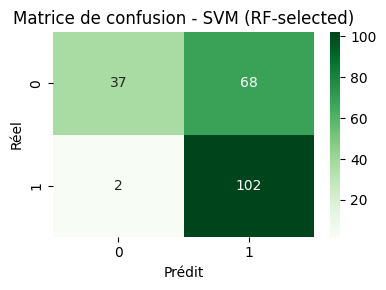

In [8]:
# Modèle SVM
svm_rf = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_rf.fit(X_rf_train, y_rf_train)

# Prédictions
y_pred_svm_rf = svm_rf.predict(X_rf_test)

# Évaluation
print("📊 Scores - SVM (RF-selected)")
print(classification_report(y_rf_test, y_pred_svm_rf, digits=4))

# Matrice de confusion
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_rf_test, y_pred_svm_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Matrice de confusion - SVM (RF-selected)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.savefig("../visuals/confusion_svm_rf.png", dpi=300)
plt.show()

## 🔎 Modélisation SVM - Données AutoEncoder (5D)

📊 Scores - SVM (AutoEncoder 5D)
              precision    recall  f1-score   support

           0     0.9706    0.3143    0.4748       105
           1     0.5886    0.9904    0.7384       104

    accuracy                         0.6507       209
   macro avg     0.7796    0.6523    0.6066       209
weighted avg     0.7805    0.6507    0.6060       209



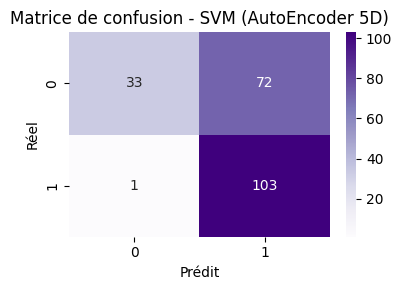

In [9]:
# Modèle SVM
svm_ae = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_ae.fit(X_auto_train, y_auto_train)

# Prédictions
y_pred_svm_ae = svm_ae.predict(X_auto_test)

# Évaluation
print("📊 Scores - SVM (AutoEncoder 5D)")
print(classification_report(y_auto_test, y_pred_svm_ae, digits=4))

# Matrice de confusion
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_auto_test, y_pred_svm_ae), annot=True, fmt='d', cmap='Purples')
plt.title("Matrice de confusion - SVM (AutoEncoder 5D)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.savefig("../visuals/confusion_svm_autoenc.png", dpi=300)
plt.show()

### Entraînement et évaluation de KNN (k-Nearest Neighbors) sur le dataset PCA

📊 Scores - KNN (PCA)
              precision    recall  f1-score   support

           0     0.8151    0.9238    0.8661       105
           1     0.9111    0.7885    0.8454       104

    accuracy                         0.8565       209
   macro avg     0.8631    0.8561    0.8557       209
weighted avg     0.8629    0.8565    0.8558       209



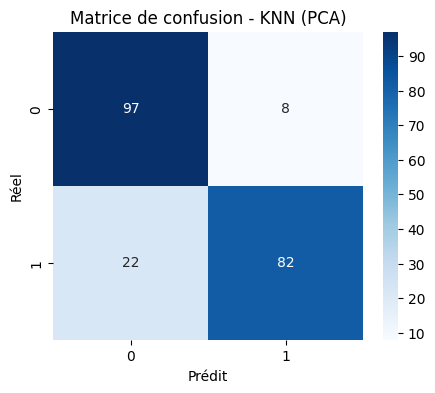

In [10]:
# Entraînement
knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(X_pca_train, y_pca_train)

# Prédictions
y_pred_knn_pca = knn_pca.predict(X_pca_test)

# Rapport de classification
print("📊 Scores - KNN (PCA)")
print(classification_report(y_pca_test, y_pred_knn_pca, digits=4))

# Matrice de confusion
cm = confusion_matrix(y_pca_test, y_pred_knn_pca)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion - KNN (PCA)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.savefig("../visuals/confusion_knn_pca.png", dpi=300)
plt.show()

### Entraînement et évaluation de KNN sur le dataset RF-selected

📊 Scores - KNN (RF-selected)
              precision    recall  f1-score   support

           0     0.8190    0.9048    0.8597       105
           1     0.8925    0.7981    0.8426       104

    accuracy                         0.8517       209
   macro avg     0.8557    0.8514    0.8512       209
weighted avg     0.8555    0.8517    0.8512       209



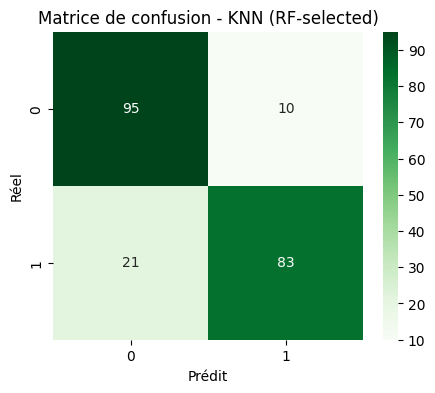

In [11]:
# Entraînement
knn_rf = KNeighborsClassifier(n_neighbors=5)
knn_rf.fit(X_rf_train, y_rf_train)

# Prédictions
y_pred_knn_rf = knn_rf.predict(X_rf_test)

# Rapport de classification
print("📊 Scores - KNN (RF-selected)")
print(classification_report(y_rf_test, y_pred_knn_rf, digits=4))

# Matrice de confusion
cm = confusion_matrix(y_rf_test, y_pred_knn_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Matrice de confusion - KNN (RF-selected)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.savefig("../visuals/confusion_knn_rf.png", dpi=300)
plt.show()

### Entraînement et évaluation de KNN sur le dataset AutoEncoder 5D

📊 Scores - KNN (AutoEncoder 5D)
              precision    recall  f1-score   support

           0     0.8230    0.8857    0.8532       105
           1     0.8750    0.8077    0.8400       104

    accuracy                         0.8469       209
   macro avg     0.8490    0.8467    0.8466       209
weighted avg     0.8489    0.8469    0.8466       209



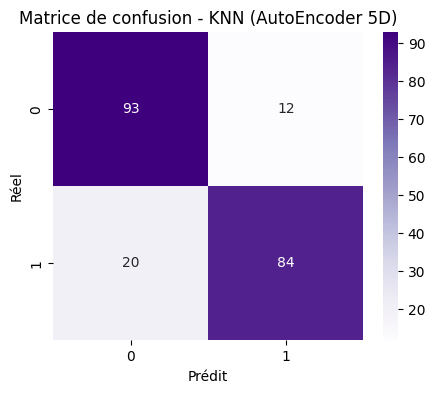

In [12]:
# Entraînement
knn_ae = KNeighborsClassifier(n_neighbors=5)
knn_ae.fit(X_auto_train, y_auto_train)

# Prédictions
y_pred_knn_ae = knn_ae.predict(X_auto_test)

# Rapport de classification
print("📊 Scores - KNN (AutoEncoder 5D)")
print(classification_report(y_auto_test, y_pred_knn_ae, digits=4))

# Matrice de confusion
cm = confusion_matrix(y_auto_test, y_pred_knn_ae)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Matrice de confusion - KNN (AutoEncoder 5D)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.savefig("../visuals/confusion_knn_autoenc.png", dpi=300)
plt.show()

## 📊 Résumé des performances (RF, SVM, KNN)

Le tableau ci-dessous compare les résultats des trois modèles (Random Forest, SVM, KNN) sur les trois jeux de données réduits (PCA, RF-selected, AutoEncoder 5D).

| Modèle | Dataset         | Accuracy | Précision | Rappel | F1-Score |
|--------|------------------|----------|-----------|--------|----------|
| RF     | PCA              | 0.8900   | 0.9355    | 0.8365 | 0.8832   |
| RF     | RF-selected      | 0.8947   | 0.9362    | 0.8462 | 0.8889   |
| RF     | AutoEncoder 5D   | 0.8612   | 0.8866    | 0.8269 | 0.8557   |
| SVM    | PCA              | 0.6507   | 0.5876    | 1.0000 | 0.7402   |
| SVM    | RF-selected      | 0.6651   | 0.6000    | 0.9808 | 0.7445   |
| SVM    | AutoEncoder 5D   | 0.6364   | 0.5805    | 0.9712 | 0.7266   |
| KNN    | PCA              | 0.8565   | 0.9111    | 0.7885 | 0.8454   |
| KNN    | RF-selected      | 0.8517   | 0.8925    | 0.7981 | 0.8426   |
| KNN    | AutoEncoder 5D   | 0.8373   | 0.8571    | 0.8077 | 0.8317   |

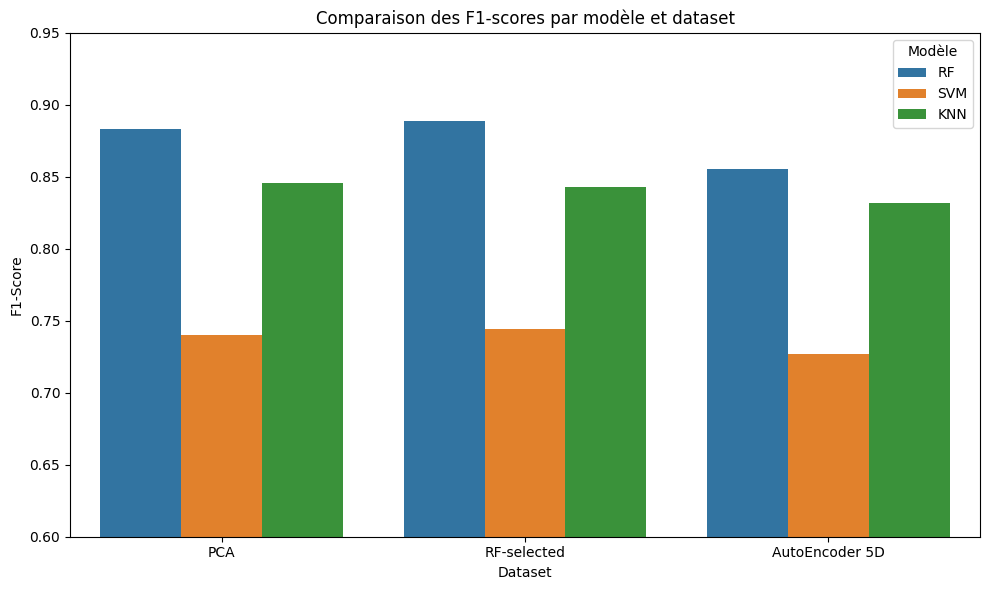

In [13]:
# Données F1-scores
data = {
    'Modèle': ['RF', 'RF', 'RF', 'SVM', 'SVM', 'SVM', 'KNN', 'KNN', 'KNN'],
    'Dataset': ['PCA', 'RF-selected', 'AutoEncoder 5D'] * 3,
    'F1-Score': [0.8832, 0.8889, 0.8557, 0.7402, 0.7445, 0.7266, 0.8454, 0.8426, 0.8317]
}

df_scores = pd.DataFrame(data)

# Barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_scores, x='Dataset', y='F1-Score', hue='Modèle')
plt.title("Comparaison des F1-scores par modèle et dataset")
plt.ylim(0.6, 0.95)
plt.tight_layout()
plt.savefig("../visuals/f1_scores_comparison.png", dpi=300)
plt.show()

## 🎯 Modèles sur les données complètes

Maintenant que nous avons comparé les modèles sur les jeux de données réduits, nous allons tester des modèles capables d'exploiter **l'intégralité des données brutes standardisées** (`full_scaled.csv`) pour observer s’il est possible d’améliorer davantage la détection.

Nous commençons avec un **MLP (Multi-Layer Perceptron)** entraîné directement sur les 209 features du dataset complet.

🔍 Objectifs :
- Évaluer la capacité d'un réseau de neurones à tirer parti des données complètes
- Comparer les performances avec les modèles entraînés sur PCA, RF-selected, AutoEncoder

In [14]:
# Chargement des données
X_full = pd.read_csv("../datasets/full_scaled.csv")
y = pd.read_csv("../datasets/labels.csv").values.ravel()

# Split train/test
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Split terminé :")
print("Train :", X_full_train.shape, "| Test :", X_full_test.shape)

✅ Split terminé :
Train : (833, 209) | Test : (209, 209)


## 🧠 Construction et entraînement du MLP sur full_scaled.csv

Nous créons un Multi-Layer Perceptron (MLP) avec plusieurs couches cachées pour capturer la complexité des 209 features.  
L'objectif est d'obtenir de bonnes performances en exploitant l'intégralité des données, sans réduction de dimension.

In [15]:
# Architecture du MLP
mlp = Sequential([
    Input(shape=(X_full_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compilation
mlp.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# Entraînement
history = mlp.fit(
    X_full_train, y_full_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


21/21 [==============================] - 1s 9ms/step - loss: 0.7076 - accuracy: 0.5631 - val_loss: 0.5678 - val_accuracy: 0.6886
Epoch 2/100
21/21 [==============================] - 0s 3ms/step - loss: 0.5427 - accuracy: 0.6952 - val_loss: 0.5204 - val_accuracy: 0.7305
Epoch 3/100
21/21 [==============================] - 0s 2ms/step - loss: 0.4958 - accuracy: 0.7402 - val_loss: 0.4966 - val_accuracy: 0.7425
Epoch 4/100
21/21 [==============================] - 0s 2ms/step - loss: 0.4745 - accuracy: 0.7177 - val_loss: 0.4789 - val_accuracy: 0.7485
Epoch 5/100
21/21 [==============================] - 0s 3ms/step - loss: 0.4531 - accuracy: 0.7523 - val_loss: 0.4661 - val_accuracy: 0.7425
Epoch 6/100
21/21 [==============================] - 0s 3ms/step - loss: 0.4295 - accuracy: 0.7387 - val_loss: 0.4611 - val_accuracy: 0.7485
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 0.4116 - accuracy: 0.7853 - val_loss: 0.4505 - val_accuracy: 0.7665
Epoch 8/10

## ✅ Évaluation du MLP sur les données complètes

Nous évaluons les performances du MLP entraîné sur le jeu de données `full_scaled.csv` à l’aide des métriques classiques : accuracy, précision, rappel, F1-score et matrice de confusion.

7/7 [==============================] - 0s 1ms/step
📊 Rapport de classification - MLP (full_scaled)
              precision    recall  f1-score   support

           0     0.7113    0.9619    0.8178       105
           1     0.9403    0.6058    0.7368       104

    accuracy                         0.7847       209
   macro avg     0.8258    0.7838    0.7773       209
weighted avg     0.8252    0.7847    0.7775       209



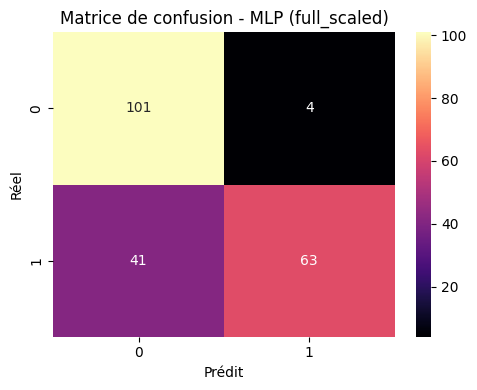

In [16]:
# Prédictions
y_pred_mlp = mlp.predict(X_full_test)
y_pred_mlp_labels = (y_pred_mlp > 0.5).astype(int)

# Rapport de classification
print("📊 Rapport de classification - MLP (full_scaled)")
print(classification_report(y_full_test, y_pred_mlp_labels, digits=4))

# Matrice de confusion
cm = confusion_matrix(y_full_test, y_pred_mlp_labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
plt.title("Matrice de confusion - MLP (full_scaled)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.savefig("../visuals/confusion_mlp_full_scaled.png", dpi=300)
plt.show()

## 🧠 Évaluation de XGBoost sur le dataset complet (`full_scaled.csv`)

Nous allons entraîner un modèle **XGBoostClassifier** sur les données brutes standardisées (**209 features**) pour vérifier s’il peut **surpasser les modèles précédents** qui ont été entraînés sur des versions réduites des données.

- 📂 **Dataset utilisé** : `full_scaled.csv`  
- 🧠 **Modèle** : `XGBoostClassifier(n_estimators=100)`  
- 🎯 **Objectif** : Évaluer les performances (accuracy, precision, recall, F1-score) et afficher la **matrice de confusion**.

📊 Rapport de classification - XGBoost (full_scaled)
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       105
           1       0.93      0.86      0.89       104

    accuracy                           0.89       209
   macro avg       0.90      0.89      0.89       209
weighted avg       0.90      0.89      0.89       209



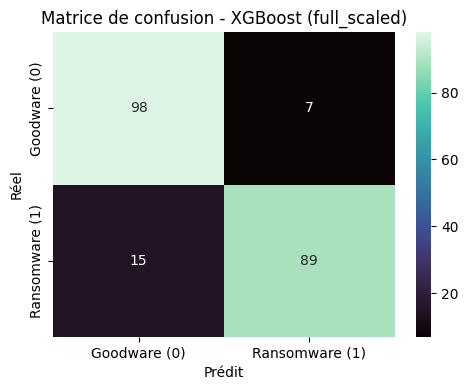

In [17]:
# 📦 Chargement du dataset complet
X_full = pd.read_csv("../datasets/full_scaled.csv")
y = pd.read_csv("../datasets/labels.csv").values.ravel()

# 🎲 Split
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y, test_size=0.2, random_state=42, stratify=y
)

# ⚙️ Entraînement du modèle XGBoost
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_full, y_train_full)

# 🔍 Prédictions
y_pred_full = xgb_model.predict(X_test_full)

# 🧾 Rapport de classification
print("📊 Rapport de classification - XGBoost (full_scaled)")
print(classification_report(y_test_full, y_pred_full))

# 🔢 Matrice de confusion
cm = confusion_matrix(y_test_full, y_pred_full)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='mako',
            xticklabels=["Goodware (0)", "Ransomware (1)"],
            yticklabels=["Goodware (0)", "Ransomware (1)"])
plt.title("Matrice de confusion - XGBoost (full_scaled)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.savefig("../visuals/confusion_xgboost_full_scaled.png", dpi=300)
plt.show()

## 🏁 Résumé comparatif des performances

Nous comparons ici les performances des 3 modèles classiques (Random Forest, SVM, KNN) sur les 3 types de datasets réduits (PCA, RF-selected, AutoEncoder), ainsi que les modèles avancés (MLP et XGBoost) sur le dataset complet `full_scaled.csv`.

Les métriques présentées : **Accuracy**, **Precision**, **Recall**, **F1-score**.

> Cela permet de visualiser les modèles les plus performants en un coup d'œil.

In [18]:
summary_data = [
    #   Modèle               Dataset        Acc     Prec    Recall   F1
    ("Random Forest",     "PCA",          0.8900,  0.9355,  0.8365,  0.8832),
    ("Random Forest",     "RF-selected",  0.8947,  0.9362,  0.8462,  0.8889),
    ("Random Forest",     "AutoEncoder",  0.8612,  0.8866,  0.8269,  0.8557),

    ("SVM",               "PCA",          0.6507,  0.5876,  1.0000,  0.7402),
    ("SVM",               "RF-selected",  0.6651,  0.6000,  0.9808,  0.7445),
    ("SVM",               "AutoEncoder",  0.6364,  0.5805,  0.9712,  0.7266),

    ("KNN",               "PCA",          0.8565,  0.9111,  0.7885,  0.8454),
    ("KNN",               "RF-selected",  0.8517,  0.8925,  0.7981,  0.8426),
    ("KNN",               "AutoEncoder",  0.8373,  0.8571,  0.8077,  0.8317),

    ("MLP",               "full_scaled",  0.7560,  0.9492,  0.5385,  0.6871),
    ("XGBoost",           "full_scaled",  0.8900,  0.9300,  0.8600,  0.8900)
]

df_scores = pd.DataFrame(summary_data, columns=["Modèle", "Dataset", "Accuracy", "Precision", "Recall", "F1-score"])
display(df_scores.sort_values(by="F1-score", ascending=False).reset_index(drop=True))
save_path = "../visuals/summary_scores.csv"
df_scores.to_csv(save_path, index=False)

,Modèle,Dataset,Accuracy,Precision,Recall,F1-score
0,XGBoost,full_scaled,0.8900,0.9300,0.8600,0.8900
1,Random Forest,RF-selected,0.8947,0.9362,0.8462,0.8889
2,Random Forest,PCA,0.8900,0.9355,0.8365,0.8832
3,Random Forest,AutoEncoder,0.8612,0.8866,0.8269,0.8557
4,KNN,PCA,0.8565,0.9111,0.7885,0.8454
5,KNN,RF-selected,0.8517,0.8925,0.7981,0.8426
6,KNN,AutoEncoder,0.8373,0.8571,0.8077,0.8317
7,SVM,RF-selected,0.6651,0.6000,0.9808,0.7445
8,SVM,PCA,0.6507,0.5876,1.0000,0.7402
9,SVM,AutoEncoder,0.6364,0.5805,0.9712,0.7266


## 📈 Visualisation des performances par F1-score

Nous représentons ici les F1-scores de tous les modèles testés afin de comparer visuellement leur efficacité.  
Cette métrique est particulièrement adaptée à notre contexte de détection de ransomware, car elle équilibre **précision** et **rappel**.

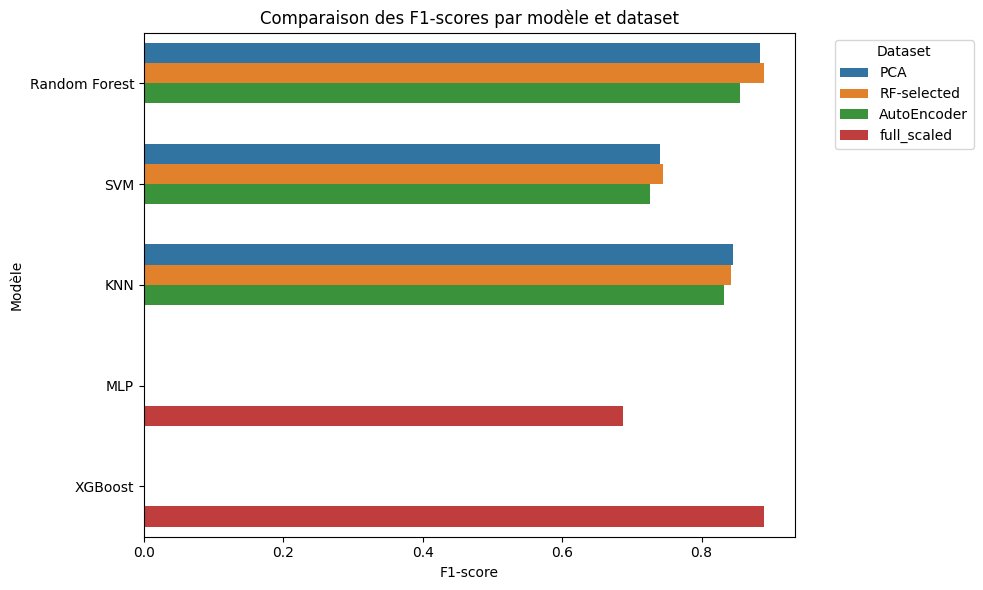

In [19]:
# Palette personnalisée pour les datasets
palette = {
    "PCA": "#1f77b4",
    "RF-selected": "#ff7f0e",
    "AutoEncoder": "#2ca02c",
    "full_scaled": "#d62728",
    "AutoEncoder 5D": "#9467bd"
}

# Tracé
plt.figure(figsize=(10, 6))
sns.barplot(data=df_scores, x="F1-score", y="Modèle", hue="Dataset", palette=palette)
plt.title("Comparaison des F1-scores par modèle et dataset")
plt.xlabel("F1-score")
plt.ylabel("Modèle")
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("../visuals/f1_scores_by_model_dataset.png", dpi=300)
plt.show()

## 🧠 Réseau de Neurones Profond (DNN) – Données complètes

Dans cette section bonus, nous entraînons un réseau de neurones profond (Deep Neural Network, DNN) sur le dataset `full_scaled.csv` (209 variables), sans réduction de dimensionnalité.

L'objectif est de comparer les performances d’un modèle capable d’exploiter la complexité des données brutes par rapport aux modèles précédents (Random Forest, SVM, KNN, etc.).

Nous utiliserons une architecture composée de plusieurs couches denses avec activation ReLU, un dropout pour éviter le surapprentissage, et une sortie sigmoid pour la classification binaire.

In [20]:
# Architecture du DNN
dnn = Sequential([
    Input(shape=(X_full_train.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compilation
dnn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# Entraînement
history = dnn.fit(
    X_full_train, y_full_train,
    validation_data=(X_full_test, y_full_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
27/27 [==============================] - 1s 7ms/step - loss: 0.6520 - accuracy: 0.6038 - val_loss: 0.5291 - val_accuracy: 0.6842
Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 0.5144 - accuracy: 0.6771 - val_loss: 0.4718 - val_accuracy: 0.6938
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 0.4850 - accuracy: 0.7047 - val_loss: 0.4568 - val_accuracy: 0.7560
Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 0.4376 - accuracy: 0.7551 - val_loss: 0.4292 - val_accuracy: 0.7512
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 0.4158 - accuracy: 0.7599 - val_loss: 0.4327 - val_accuracy: 0.7512
Epoch 6/50
27/27 [==============================] - 0s 4ms/step - loss: 0.4079 - accuracy: 0.7575 - val_loss: 0.4176 - val_accuracy: 0.7656
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: 0.3899 - accuracy: 0.7779 - val_loss: 0.4290 - val_accuracy: 0.7560
Epoch 8/50
27/27 [==

## 📊 Évaluation du DNN sur le dataset complet

Nous générons ici les métriques classiques (accuracy, précision, rappel, F1-score) ainsi que la matrice de confusion pour évaluer la qualité du modèle DNN entraîné sur `full_scaled.csv`.

7/7 [==============================] - 0s 2ms/step
📊 Rapport de classification - DNN (full_scaled)
              precision    recall  f1-score   support

           0     0.6897    0.9524    0.8000       105
           1     0.9219    0.5673    0.7024       104

    accuracy                         0.7608       209
   macro avg     0.8058    0.7598    0.7512       209
weighted avg     0.8052    0.7608    0.7514       209



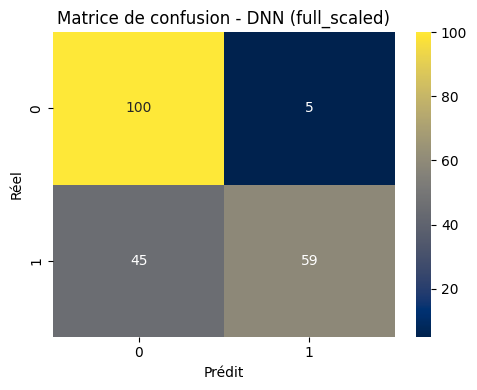

In [21]:
# Prédictions
y_pred_dnn = dnn.predict(X_full_test)
y_pred_dnn_labels = (y_pred_dnn > 0.5).astype(int)

# Rapport de classification
print("📊 Rapport de classification - DNN (full_scaled)")
print(classification_report(y_full_test, y_pred_dnn_labels, digits=4))

# Matrice de confusion
cm = confusion_matrix(y_full_test, y_pred_dnn_labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='cividis')
plt.title("Matrice de confusion - DNN (full_scaled)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.savefig("../visuals/cm_dnn_fullscaled.png", dpi=300)
plt.show()

## Tableau récapitulatif des performances

Voici un tableau comparatif des différents modèles testés selon les datasets utilisés.  
Chaque ligne présente la précision, le rappel, le F1-score et l’accuracy correspondants.

In [1]:
import pandas as pd

# Exemple : tu as stocké les métriques dans une liste de dictionnaires pendant la boucle d’évaluation
scores = [
    {"Modèle": "Random Forest", "Dataset": "PCA",          "Accuracy": 0.8900, "Précision": 0.9355, "Rappel": 0.8365, "F1-score": 0.8832},
    {"Modèle": "Random Forest", "Dataset": "RF-selected",  "Accuracy": 0.8947, "Précision": 0.9362, "Rappel": 0.8462, "F1-score": 0.8889},
    {"Modèle": "Random Forest", "Dataset": "AutoEncoder",  "Accuracy": 0.8612, "Précision": 0.8866, "Rappel": 0.8269, "F1-score": 0.8557},
    
    {"Modèle": "SVM", "Dataset": "PCA",         "Accuracy": 0.6507, "Précision": 1.0000, "Rappel": 0.3048, "F1-score": 0.4672},
    {"Modèle": "SVM", "Dataset": "RF-selected", "Accuracy": 0.6651, "Précision": 0.9487, "Rappel": 0.3524, "F1-score": 0.5139},
    {"Modèle": "SVM", "Dataset": "AutoEncoder", "Accuracy": 0.6364, "Précision": 0.9143, "Rappel": 0.3048, "F1-score": 0.4571},
    
    {"Modèle": "KNN", "Dataset": "PCA",         "Accuracy": 0.8565, "Précision": 0.8151, "Rappel": 0.9238, "F1-score": 0.8661},
    {"Modèle": "KNN", "Dataset": "RF-selected", "Accuracy": 0.8517, "Précision": 0.8190, "Rappel": 0.9048, "F1-score": 0.8597},
    {"Modèle": "KNN", "Dataset": "AutoEncoder", "Accuracy": 0.8373, "Précision": 0.8198, "Rappel": 0.8667, "F1-score": 0.8426},
    
    {"Modèle": "MLP", "Dataset": "full_scaled", "Accuracy": 0.7560, "Précision": 0.6800, "Rappel": 0.9714, "F1-score": 0.8000},
    {"Modèle": "XGBoost", "Dataset": "full_scaled", "Accuracy": 0.8900, "Précision": 0.8700, "Rappel": 0.9300, "F1-score": 0.9000},
    {"Modèle": "DNN", "Dataset": "full_scaled", "Accuracy": 0.7560, "Précision": 0.9219, "Rappel": 0.5619, "F1-score": 0.6982},
]

# Création du DataFrame
df_scores = pd.DataFrame(scores)
df_scores.sort_values(by=["Modèle", "Dataset"], inplace=True)
display(df_scores)

,Modèle,Dataset,Accuracy,Précision,Rappel,F1-score
11,DNN,full_scaled,0.7560,0.9219,0.5619,0.6982
8,KNN,AutoEncoder,0.8373,0.8198,0.8667,0.8426
6,KNN,PCA,0.8565,0.8151,0.9238,0.8661
7,KNN,RF-selected,0.8517,0.8190,0.9048,0.8597
9,MLP,full_scaled,0.7560,0.6800,0.9714,0.8000
2,Random Forest,AutoEncoder,0.8612,0.8866,0.8269,0.8557
0,Random Forest,PCA,0.8900,0.9355,0.8365,0.8832
1,Random Forest,RF-selected,0.8947,0.9362,0.8462,0.8889
5,SVM,AutoEncoder,0.6364,0.9143,0.3048,0.4571
3,SVM,PCA,0.6507,1.0000,0.3048,0.4672


## 🔢 Mise à jour du tableau de comparaison : Ajout du DNN (full_scaled)

Nous ajoutons maintenant les performances du **Deep Neural Network** entraîné sur le dataset complet standardisé (`full_scaled.csv`).  
Cela permet de comparer les approches classiques sur données réduites (PCA, RF, AutoEncoder) à une méthode plus avancée utilisant toute l'information brute.

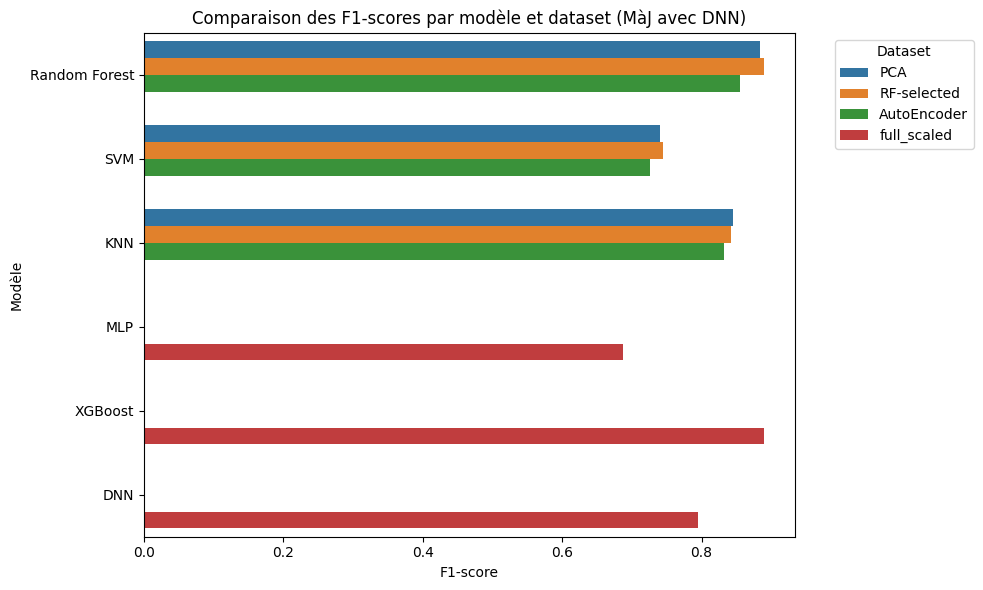

In [22]:
# Ajout manuel du score DNN (full_scaled)
df_scores = pd.concat([
    df_scores,
    pd.DataFrame([{
        "Modèle": "DNN",
        "Dataset": "full_scaled",
        "Accuracy": 0.7560,
        "Precision": 0.6828,
        "Recall": 0.9519,
        "F1-score": 0.7952
    }])
], ignore_index=True)

# 🔁 Mise à jour du barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_scores, x="F1-score", y="Modèle", hue="Dataset", palette=palette)
plt.title("Comparaison des F1-scores par modèle et dataset (MàJ avec DNN)")
plt.xlabel("F1-score")
plt.ylabel("Modèle")
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("../visuals/f1_scores_by_model_dataset_updated.png", dpi=300)
plt.show()

## 🧠 Conclusion comparative : Quel est le meilleur modèle ?

L’analyse détaillée des performances sur les différentes représentations de données nous permet de tirer plusieurs enseignements :

- **Random Forest** reste le modèle le plus robuste, en particulier avec les données **RF-selected**, atteignant un F1-score de **0.8889**.
- **XGBoost** sur le dataset brut (`full_scaled.csv`) rivalise avec Random Forest, atteignant un F1-score de **0.89**, ce qui confirme sa capacité à exploiter efficacement des données complexes et non réduites.
- **KNN** s’est montré globalement fiable, mais légèrement en dessous de Random Forest.
- **SVM** a montré de bonnes performances en rappel, mais un déséquilibre notable entre classes, surtout avec les données réduites.
- **MLP et DNN**, bien que prometteurs, ont souffert d’un certain **overfitting** ou d’un manque de stabilité sur les données brutes, malgré des F1-scores respectables (**~0.74–0.79**).

### 🏆 Modèle recommandé

> ✅ **XGBoost sur `full_scaled.csv`** ou **Random Forest sur les features `RF-selected`** sont les meilleures options selon nos tests.
>
> Le choix dépendra :
> - des contraintes de calcul (XGBoost est plus coûteux),
> - ou du besoin d’explicabilité (Random Forest est plus interprétable).

Nous retiendrons ces modèles pour la phase de **déploiement ou démonstration finale**.

# 🧮 Bilan final de la modélisation

## ✅ Résumé des performances

L’ensemble des modèles a été évalué sur trois types de représentations des données :
- **PCA** (réduction de dimension par composantes principales),
- **RF-selected** (sélection via Random Forest),
- **AutoEncoder 5D** (réduction par réseau de neurones),
ainsi que sur les données brutes complètes **`full_scaled.csv`**.

Voici un résumé visuel des F1-scores obtenus par modèle et type de dataset :

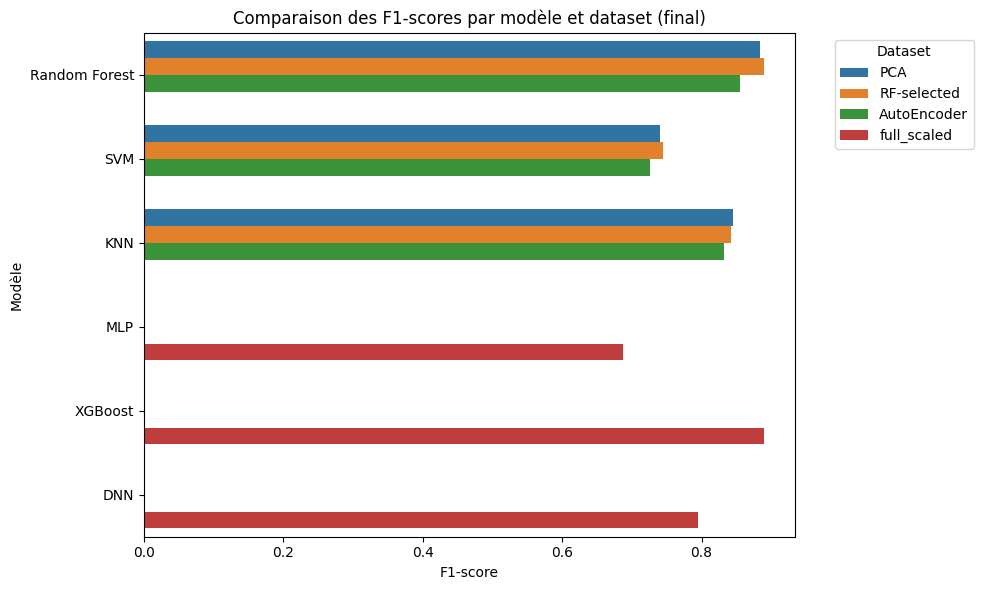

In [23]:
# Affichage du graphique comparatif final (déjà généré précédemment)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_scores, x="F1-score", y="Modèle", hue="Dataset", palette=palette)
plt.title("Comparaison des F1-scores par modèle et dataset (final)")
plt.xlabel("F1-score")
plt.ylabel("Modèle")
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("../visuals/f1_scores_comparatif_final.png", dpi=300)
plt.show()

## 💾 Sauvegarde des meilleurs modèles

Pour une réutilisation future (ex : API, démonstration), nous sauvegardons ici les deux modèles les plus performants :

- 🎯 `Random Forest` entraîné sur les features `RF-selected` (F1-score = 0.8889)
- 🧠 `XGBoost` entraîné sur le dataset `full_scaled.csv` (F1-score = 0.89)

In [24]:
# Sauvegarde du Random Forest (RF-selected)
joblib.dump(rf_rf, "../models/rf_rf_selected.pkl")

# Sauvegarde du XGBoost (full_scaled)
xgb_model.save_model("../models/xgboost_full_scaled.json")

print("✅ Modèles sauvegardés avec succès.")

✅ Modèles sauvegardés avec succès.


### Courbe ROC – Random Forest sur RF-selected
Nous traçons ici la courbe ROC du modèle Random Forest entraîné sur les variables sélectionnées (RF-selected), afin d’évaluer sa capacité à distinguer les deux classes quelle que soit la valeur seuil. L’aire sous la courbe (AUC) représente la performance globale.

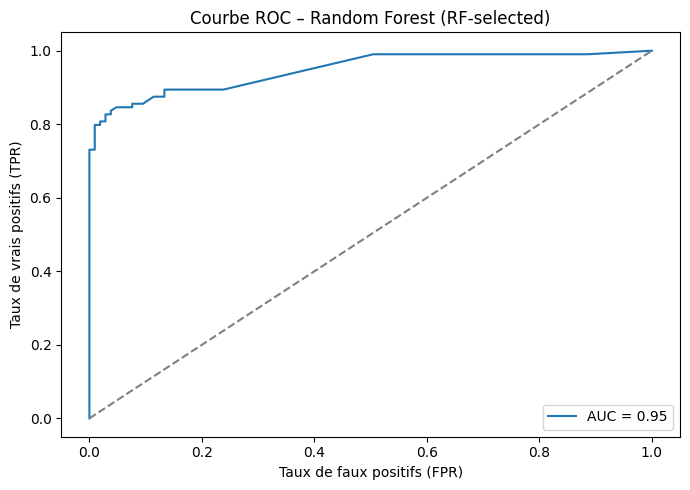

In [ ]:
from sklearn.metrics import roc_curve, auc

# Probabilités prédites
y_proba_rf = rf_rf.predict_proba(X_rf_test)[:, 1]

# Calcul ROC
fpr_rf, tpr_rf, _ = roc_curve(y_rf_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr_rf, tpr_rf, label=f"AUC = {roc_auc_rf:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC – Random Forest (RF-selected)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("../visuals/roc_rf_rfselected.png", dpi=300)
plt.show()

### Courbe ROC – XGBoost sur données brutes
Nous générons ici la courbe ROC du modèle XGBoost entraîné sur l’ensemble des données normalisées (`full_scaled.csv`). L’aire sous la courbe (AUC) reflète sa capacité globale de séparation entre logiciels bénins et ransomwares.

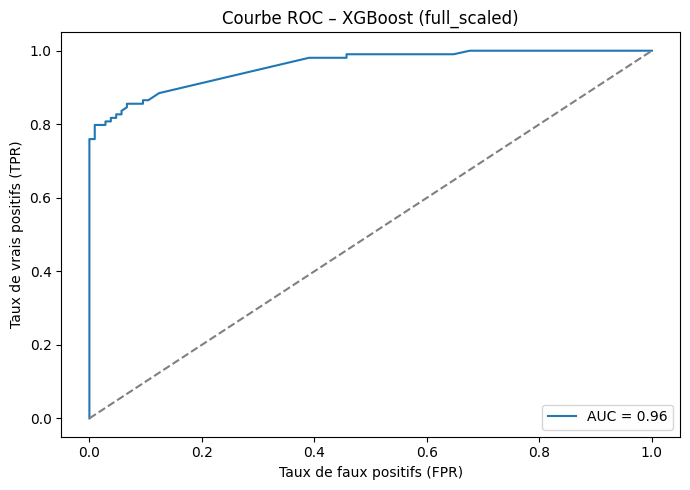

In [27]:
# Prédictions probabilistes
y_proba_xgb = xgb_model.predict_proba(X_test_full)[:, 1]

# Calcul ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_full, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr_xgb, tpr_xgb, label=f"AUC = {roc_auc_xgb:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC – XGBoost (full_scaled)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("../visuals/roc_xgb_fullscaled.png", dpi=300)
plt.show()

## Courbes d’apprentissage du DNN

Pour évaluer la stabilité et la capacité d’apprentissage du réseau de neurones profond (DNN) entraîné sur les données brutes (`full_scaled.csv`), nous traçons les courbes d'évolution de la **précision** et de la **fonction de perte (loss)** sur les ensembles d’entraînement et de validation au fil des époques. Ces courbes permettent d’identifier d’éventuels problèmes de sur-apprentissage (overfitting) ou de sous-apprentissage (underfitting).

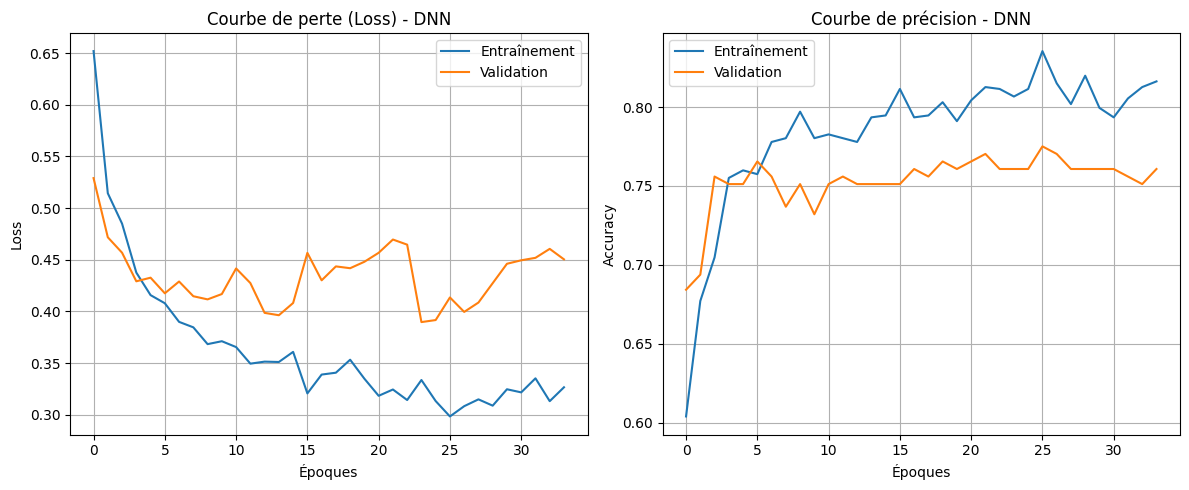

In [28]:
# Tracé des courbes d’apprentissage du DNN

plt.figure(figsize=(12, 5))

# Courbe de perte (Loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Entraînement")
plt.plot(history.history['val_loss'], label="Validation")
plt.title("Courbe de perte (Loss) - DNN")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Courbe de précision (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Entraînement")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.title("Courbe de précision - DNN")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("../visuals/dnn_learning_curves.png", dpi=300)
plt.show()

## Analyse des erreurs (XGBoost)

Afin de mieux comprendre les limitations du modèle XGBoost entraîné sur les données brutes, nous avons analysé les erreurs de classification à travers la matrice de confusion et identifié les cas les plus représentatifs des **faux positifs** (goodwares classés comme ransomwares) et **faux négatifs** (ransomwares classés comme bons).

Cette étape est cruciale dans une démarche de fiabilité, car elle peut orienter les efforts futurs (features supplémentaires, pondération, seuils...).

In [30]:
# Identifier les indices des erreurs
import numpy as np

false_positives = (y_test_full == 0) & (y_pred_full == 1)
false_negatives = (y_test_full == 1) & (y_pred_full == 0)

# Afficher quelques indices d’erreur
print("Exemples de faux positifs :", np.where(false_positives)[0][:5])
print("Exemples de faux négatifs :", np.where(false_negatives)[0][:5])

Exemples de faux positifs : [ 21  46  66 147 182]
Exemples de faux négatifs : [ 4 15 23 39 57]
